# Uitwerkingen Les 2 : Opgave 1 (2e orde)

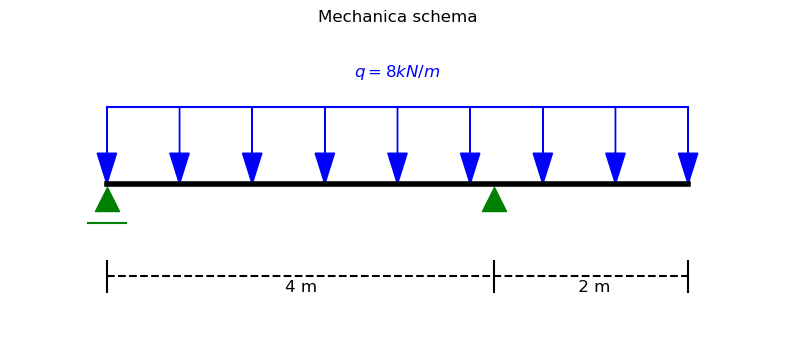

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Instellen van de balklengte en belastingen
balk_lengte = 6  # meters
verdeelde_belasting = 8  # kN/m
koppel_locatie = 6  # meters
koppel_waarde = 160  # kNm (met de klok mee)

# Coördinaten van de ondersteuningen
ondersteuning_links = 0  # Rolscharnier
ondersteuning_rechts = 4  # Gewone scharnier

# Instellen van de figuur
fig, ax = plt.subplots(figsize=(10, 4))

# Tekenen van de balk
ax.plot([0, balk_lengte], [0, 0], 'k', lw=4, label="Balk")

# Tekenen van de ondersteuningen als gevulde groene driehoeken
ax.scatter(ondersteuning_links, -0.1, marker='^', s=300, color='green', label="Rolscharnier")
ax.plot([-0.2, 0.2], [-0.25, -0.25], color='green')  # Meetlijn
ax.scatter(ondersteuning_rechts, -0.1, marker='^', s=300, color='green', label="Scharnier")

# Tekenen van de verdeelde belasting met blauwe pijlen en label
x_vals = np.linspace(0, balk_lengte, 9)  
for x in x_vals:
    ax.arrow(x, 0.5, 0, -0.3, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
ax.text(balk_lengte / 2, 0.7, r"$q = 8 kN/m$", fontsize=12, color='blue', ha='center')
ax.plot([0, balk_lengte], [0.5, 0.5], color='blue')  # Meetlijn

# Tekenen van het koppel met cirkelpijlen en blauwe label
#ax.text(koppel_locatie, 0.6, r"$M = 160\ kNm$", fontsize=12, color='blue', ha='center')
#ax.arrow(koppel_locatie - 0.3, 0.2, 0.3, 0.3, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linestyle='dashed')
#ax.arrow(koppel_locatie + 0.3, 0.2, -0.3, 0.3, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linestyle='dashed')

# Tekenen van de maatvoering onder de balk
ax.plot([0, 0], [-0.5, -0.7], 'k')  # Begin meetlijn
ax.plot([4, 4], [-0.5, -0.7], 'k')  # Begin meetlijn
ax.plot([balk_lengte, balk_lengte], [-0.5, -0.7], 'k')  # Eind meetlijn
ax.plot([0, balk_lengte], [-0.6, -0.6], 'k--')  # Meetlijn
ax.text(10 / 2, -0.7, " 2 m", fontsize=12, ha='center')
ax.text(2, -0.7, "4 m", fontsize=12, ha='center')

# Maatvoering voor koppel locatie
#ax.plot([koppel_locatie, koppel_locatie], [-0.5, -0.4], 'k')  # Markering
#ax.text(koppel_locatie, -0.55, "6 m", fontsize=12, ha='center')

# Labels en titel in overeenstemming met template
ax.set_xlim(-1, balk_lengte + 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(0, balk_lengte + 1, 1))
#ax.set_yticks([])
ax.set_xlabel(r"$x$", color="red", fontsize=14)
ax.set_ylabel(r"$z$", color="red", fontsize=14, rotation=0, labelpad=15)
ax.set_title("Mechanica schema")

# Koppelinstellingen
koppel_locatie = 6  # Positie van het koppel in meters
koppel_radius = 0.6  # Straal van de boog


# Bereken de positie van de pijlpunt op de boog
hoek_pijl = 90  # Pijlpunt bij 270 graden (onderkant boog)
pijl_x = 6.15 #koppel_locatie + (koppel_radius / 2) * np.cos(np.radians(hoek_pijl))
pijl_y = -0.25 #0.3 + (koppel_radius / 2) * np.sin(np.radians(hoek_pijl))

# Pijlpunt toevoegen aan de boog
#ax.add_patch(arc)
#ax.arrow(pijl_x, pijl_y, -0.02, -0.01, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

# Label voor het koppel
#ax.text(koppel_locatie, -.45, r"$M = 160\ kNm$", fontsize=12, color='blue', ha='center')

# Legenda
#ax.legend()

# Assen uitschakelen
ax.axis('off')
#ax.grid()

# Creëer de boog voor het koppel
#arc = patches.Arc((koppel_locatie,-0), koppel_radius, koppel_radius, angle=270, theta1=20, theta2=180, color='blue', lw=2)
#ax.add_patch(arc)

# Plot weergeven
plt.show()


In [15]:
import numpy as np
import plotly.graph_objects as go

# Gegeven parameters
L = 6       # Lengte van de balk (m)
a = 4       # Positie van rechter ondersteuning (m)
q = 8       # Verdeelde belasting (kN/m)

# Reactiekrachten berekenen
totale_last = q * L        # 8 * 6 = 48 kN
R_B = totale_last * (L / 2) / a   # momentenevenwicht om x=0 -> RB * a = qL * (L/2)
R_A = totale_last - R_B

print("R_A =", R_A, "kN")
print("R_B =", R_B, "kN")

# Discretisatie
x_values = np.linspace(0, L, 500)
V_values = np.zeros_like(x_values)

# Dwarskrachtverloop
for i, x in enumerate(x_values):
    if x <= a:   # Tussen A en B
        V_values[i] = R_A - q * x
    else:        # Tussen B en einde balk
        V_values[i] = R_A + R_B - q * x  # = q*L - q*x

# 👉 Sluit de grafiek naar V = 0 aan beide kanten
x_plot = np.concatenate(([0], x_values, [L]))
V_plot = np.concatenate(([0], V_values, [0]))

# y-as bereik zodat 0 zichtbaar blijft
y_min = min(V_plot.min(), 0)
y_max = max(V_plot.max(), 0)

# Plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x_plot,
        y=V_plot,
        mode="lines",
        name="Dwarskrachtverloop V(x)",
        line=dict(width=2),
        fill="tozeroy",                 # aftekenen naar 0
        fillcolor="rgba(0, 0, 255, 0.1)"
    )
)

# Nul-lijn
fig.add_hline(y=0, line_width=1, line_color="black")

# Layout (zelfde stijl als moment)
fig.update_layout(
    title="Dwarskrachtenlijn van de balk",
    xaxis=dict(
        title="Positie langs de balk (m)",
        showgrid=True,
        gridcolor="lightgray",
        griddash="dot",
        zeroline=True,
        zerolinecolor="black",
        dtick=1,
        range=[0, L]
    ),
    yaxis=dict(
        title="Dwarskracht V(x) [kN]",
        showgrid=True,
        gridcolor="lightgray",
        griddash="dot",
        zeroline=True,
        zerolinecolor="black",
        range=[y_min * 1.05, y_max * 1.05]
    ),
    template="simple_white"
)

fig.show()


R_A = 12.0 kN
R_B = 36.0 kN


De functie van het buigendmoment kan gevonden worden door een snede te maken. 

\begin{align}
 M = -\dfrac{1}{2}qx^2 +\dfrac{1}{2}qlx
\end{align}

De functie voor het buigendmoment is bekend en kan nu getekend worden;

In [18]:
import numpy as np
import plotly.graph_objects as go

# Gegeven parameters
L = 6        # Lengte van de balk (m)
a = 4        # Positie van rechter ondersteuning B (m)
q = 8        # Verdeelde belasting (kN/m)

# Reactiekrachten
totale_last = q * L              # 8 * 6 = 48 kN
R_B = totale_last * (L / 2) / a  # momentenevenwicht om A: RB * a = qL * (L/2)
R_A = totale_last - R_B

print(f"R_A = {R_A:.1f} kN")
print(f"R_B = {R_B:.1f} kN")

# Discretisatie van de balk
x_values = np.linspace(0, L, 500)
M_values = np.zeros_like(x_values)

# Momentverloop berekenen
for i, x in enumerate(x_values):
    if x <= a:  # Tussen A en B
        M_values[i] = R_A * x - 0.5 * q * x**2
    else:       # Tussen B en het einde van de balk
        M_values[i] = R_A * x + R_B * (x - a) - 0.5 * q * x**2

# 👉 Sluit de grafiek naar M = 0 aan beide kanten
x_plot = np.concatenate(([0], x_values, [L]))
M_plot = np.concatenate(([0], M_values, [0]))

# y-as bereik zodat 0 zichtbaar blijft
y_min = min(M_plot.min(), 0)
y_max = max(M_plot.max(), 0)

# Plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x_plot,
        y=M_plot,
        mode="lines",
        name="Momentverloop M(x)",
        line=dict(width=2),
        fill="tozeroy",                     # aftekenen naar 0
        fillcolor="rgba(255, 0, 0, 0.15)"   # rode, transparante invulling
    )
)

# Horizontale nul-lijn
fig.add_hline(y=0, line_width=1, line_color="black")

# Layout (zelfde stijl als dwarskracht)
fig.update_layout(
    title="Momentenlijn van de balk",
    xaxis=dict(
        title="Positie langs de balk (m)",
        showgrid=True,
        gridcolor="lightgray",
        griddash="dot",
        zeroline=True,
        zerolinecolor="black",
        dtick=1,
        range=[0, L]
    ),
    yaxis=dict(
        title="Moment M(x) [kNm]",
        showgrid=True,
        gridcolor="lightgray",
        griddash="dot",
        zeroline=True,
        zerolinecolor="black",
        range=[y_min * 1.05, y_max * 1.05]
    ),
    template="simple_white"
)

fig.show()


R_A = 12.0 kN
R_B = 36.0 kN


De functie voor de dwarskracht kan gevonden worden door de functie van het buigendmoment te differentiëren.

\begin{align}
 V = -qx+\dfrac{1}{2}ql
\end{align}

De functie voor de dwarskracht is bekend en kan nu getekend worden;

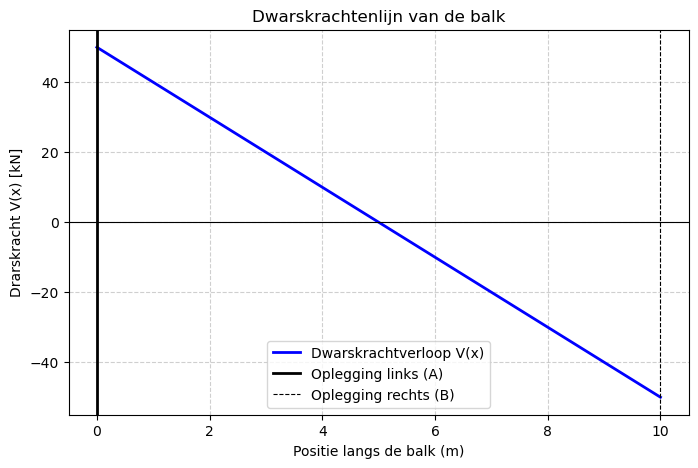

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Gegeven parameters
L = 10       # Lengte van de balk (m)
x_C = 20     # Locatie van het koppel (m)
q = 10     # Verdeelde belasting (kN/m, naar beneden)
M_C = 160   # Koppel (kNm, met de klok mee)
R_A = 20    # Reactiekracht bij A (kN)
R_B = 60    # Reactiekracht bij B (kN)

# Discretisatie van de balk
x_values = np.linspace(0, L, 500)
V_values = np.zeros_like(x_values)

# Momentverloop berekenen
for i, x in enumerate(x_values):
    if x < x_C:  # Links van het koppel
        V_values[i] = -q * x + (q / 2) * L
    else:  # Rechts van het koppel
        V_values[i] = -10 * x + 20  # Sprong in moment door koppel

# Plot de momentenlijn
plt.figure(figsize=(8, 5))
plt.plot(x_values, V_values, label="Dwarskrachtverloop V(x)", linewidth=2, color='blue')
plt.axhline(0, color='black', linewidth=0.8)
#plt.axvline(x_C, color='blue', linestyle='dashed', linewidth=1, label="Koppel bij x=6m")
plt.axvline(0, color='black', linewidth=2, label="Oplegging links (A)")
plt.axvline(L, color='black', linestyle='dashed', linewidth=0.8, label="Oplegging rechts (B)")
plt.xlabel("Positie langs de balk (m)")
plt.ylabel("Drarskracht V(x) [kN]")
plt.title("Dwarskrachtenlijn van de balk")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


De functie voor de elastische lijn (doorbuigings) kan gevonden worden door gebruik te maken van;

$EI \dfrac{d^2v}{dx^2}= M$ en deze twee keer te integreren.


\begin{align}
EI\dfrac{d^2v}{dx^2} &= M \\
EI\dfrac{d^2v}{dx^2} &= -\dfrac{1}{2}qx^2 +\dfrac{1}{2}qlx \\
EI\dfrac{dv}{dx} &= -\dfrac{1}{6}qx^3 +\dfrac{1}{4}qlx^2 + C_1 \\
EIv &= -\dfrac{1}{24}qx^4 +\dfrac{1}{12}qlx^3 + C_1x + C_2 \\
\end{align}


De integratie constanten $C_1$ en $C_2$ kunnen gevonden worden door gebruik te maken van de volgende randvoorwaardes.

Bij oplegging $A$ geldt;

$x=0, v=0$


\begin{align}
EIv &= -\dfrac{1}{24}qx^4 +\dfrac{1}{12}qlx^3 + C_1x + C_2 \\ \\
EI\cdot 0 &= -\dfrac{1}{24}q \cdot 0^4 +\dfrac{1}{12}ql \cdot 0^3 + C_1 \cdot 0 + C_2 \\\\
 0 &= -0 +0 + 0 + C_2 \\
 C_2 &= 0
\end{align}


Bij oplegging $B$ geldt;

$x=l, v=0$


\begin{align}
EIv &= -\dfrac{1}{24}qx^4 +\dfrac{1}{12}qlx^3 + C_1x + C_2 \\ \\
EI\cdot 0 &= -\dfrac{1}{24}q \cdot l^4 +\dfrac{1}{12}ql \cdot l^3 + C_1 \cdot l + C_2 \\
 0 &= -\dfrac{1}{24}ql^4 +\dfrac{1}{12}ql^4 + C_1l + C_2 \\
 0 &= \dfrac{1}{24}ql^4 + C_1l + C_2 \\
 C_1l &= -\dfrac{1}{24}ql^4 - C_2\\
 C_1 &= -\dfrac{1}{24}ql^3 - \dfrac{C_2}{l}\\
\end{align}


$C_2$ invullen geeft $C_1$:

\begin{align}
 C_1 &= -\dfrac{1}{24}ql^3 - \dfrac{C_2}{l}\\
 C_1 &= -\dfrac{1}{24}ql^3 - \dfrac{0}{l}\\
 C_1 &= -\dfrac{1}{24}ql^3 \\
\end{align}

De waardes voor $C_1$ en $C_2$ invullen geeft:


\begin{align}
EIv &= -\dfrac{1}{24}qx^4 +\dfrac{1}{12}qlx^3 + C_1x + C_2 \\
EIv &= -\dfrac{1}{24}qx^4 +\dfrac{1}{12}qlx^3 -\dfrac{1}{24}ql^3x
\end{align}


De elastischelijn (doorbuigingslijn) kan nu getekend worden;

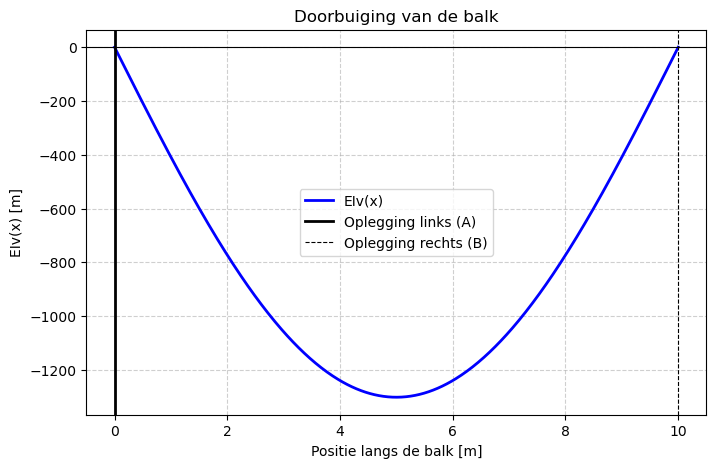

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Gegeven parameters
L = 10       # Lengte van de balk (m)
x_C = 11     # Locatie van het koppel (m)
q = 10     # Verdeelde belasting (kN/m, naar beneden)
M_C = 160   # Koppel (kNm, met de klok mee)
R_A = 20    # Reactiekracht bij A (kN)
R_B = 60    # Reactiekracht bij B (kN)

# Discretisatie van de balk
x_values = np.linspace(0, L, 500)
EIv_values = np.zeros_like(x_values)

# Momentverloop berekenen
for i, x in enumerate(x_values):
    if x < x_C:  # Links van het koppel
        EIv_values[i] = (-(1/24) * q * x**4 + (1/12) * q * L * x**3 - (1/24) * q * L**3 * x) * 1
    else:  # Rechts van het koppel
        EIv_values[i] = 0

# Plot de momentenlijn
plt.figure(figsize=(8, 5))
plt.plot(x_values, EIv_values, label="EIv(x)", linewidth=2, color='blue')
plt.axhline(0, color='black', linewidth=0.8)
#plt.axvline(x_C, color='blue', linestyle='dashed', linewidth=1, label="Koppel bij x=6m")
plt.axvline(0, color='black', linewidth=2, label="Oplegging links (A)")
plt.axvline(L, color='black', linestyle='dashed', linewidth=0.8, label="Oplegging rechts (B)")
plt.xlabel("Positie langs de balk [m]")
plt.ylabel("EIv(x) [m]")
plt.title("Doorbuiging van de balk")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


De locatie waar de doorbuiging maximaal is, kan gevonden worden door de afgeleide van de elastische lijn (doorbuigingslijn) gelijk aan 0 te stellen.

De afgeleide van de elastische lijn is de hellingsfunctie. De hellingsfunctie is bekend en kan getekend worden.


\begin{align}
    EI\dfrac{dv}{dx} &= -\dfrac{1}{6}qx^3 +\dfrac{1}{4}qlx^2 -\dfrac{1}{24}ql^3  \\
\end{align}


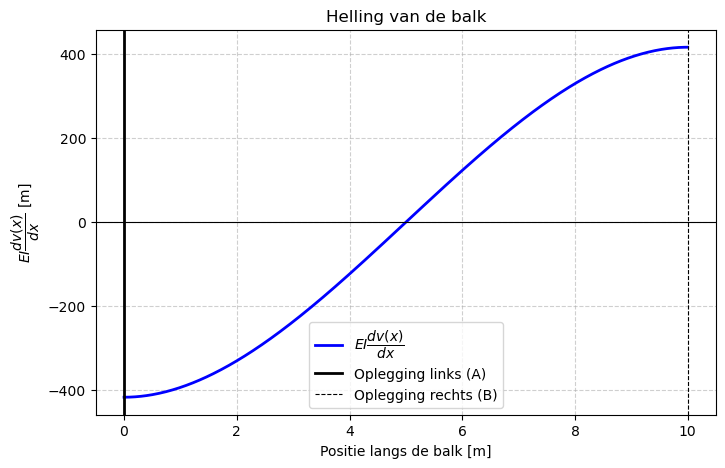

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Gegeven parameters
L = 10       # Lengte van de balk (m)
x_C = 11     # Locatie van het koppel (m)
q = 10     # Verdeelde belasting (kN/m, naar beneden)
M_C = 160   # Koppel (kNm, met de klok mee)
R_A = 20    # Reactiekracht bij A (kN)
R_B = 60    # Reactiekracht bij B (kN)

# Discretisatie van de balk
x_values = np.linspace(0, L, 500)
EIv_values = np.zeros_like(x_values)

# Momentverloop berekenen
for i, x in enumerate(x_values):
    if x < x_C:  # Links van het koppel
        EIv_values[i] = (-(1/6) * q * x**3 + (1/4) * q * L * x**2 - (1/24) * q * L**3 ) * 1
    else:  # Rechts van het koppel
        EIv_values[i] = 0

# Plot de momentenlijn
plt.figure(figsize=(8, 5))
plt.plot(x_values, EIv_values, label=r"$EI\dfrac{dv(x)}{dx}$", linewidth=2, color='blue')
plt.axhline(0, color='black', linewidth=0.8)
#plt.axvline(x_C, color='blue', linestyle='dashed', linewidth=1, label="Koppel bij x=6m")
plt.axvline(0, color='black', linewidth=2, label="Oplegging links (A)")
plt.axvline(L, color='black', linestyle='dashed', linewidth=0.8, label="Oplegging rechts (B)")
plt.xlabel("Positie langs de balk [m]")
plt.ylabel(r"$EI \dfrac{dv(x)}{dx}$ [m]")
plt.title("Helling van de balk")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


Absoluut minimuum als $EI\dfrac{dv}{dx} = 0$ , dus:


\begin{align}
EI\dfrac{dv}{dx} &= 0 \\
EI\dfrac{dv}{dx} &= -\dfrac{1}{6}qx^3 +\dfrac{1}{4}qlx^2 -\dfrac{1}{24}ql^3  =0 \\
\end{align}


Dit is een derdegraads vergelijking deze kunnen we niet analytisch oplossen.
Numeriek kunnen we de x-coordinaat van het absolute maximum wel vinden.

Vanwege symmetrie is bekend dat de hellingsfunctie gelijk is aan 0 ter plaatse van het midden van de balk, dus $x= \frac{1}{2}l$.

$x = \frac{1}{2}l$ invullen geeft $v_{max}$:



\begin{align}
EIv_{max} &= -\dfrac{1}{24}qx^4 +\dfrac{1}{12}qlx^3 -\dfrac{1}{24}ql^3x \\
EIv_{max} &= -\dfrac{1}{24}q (\frac{1}{2}l)^4 +\dfrac{1}{12}ql (\frac{1}{2}l)^3 -\dfrac{1}{24}ql^3 (\frac{1}{2}l) \\
EIv_{max} &= -\dfrac{1}{24}q \frac{1}{16}l^4 +\dfrac{1}{12}ql \frac{1}{8}l^3 -\dfrac{1}{24}ql^3 \frac{1}{2}l \\
EIv_{max} &= -\dfrac{1}{384}ql^4 +\dfrac{1}{96}ql^4 -\dfrac{1}{48}ql^4  \\
EIv_{max} &= -\dfrac{5}{384}ql^4 \\
v_{max} &= -\dfrac{5}{384EI}ql^4 \\
\end{align}



In [34]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ========================
# Gegeven parameters
# ========================
L = 6        # Lengte balk (m)
a = 4        # Positie ondersteuning B (m)
q = 8        # Verdeelde belasting (kN/m)

# Reactiekrachten
totale_last = q * L
R_B = totale_last * (L / 2) / a
R_A = totale_last - R_B

print(f"R_A = {R_A:.1f} kN")
print(f"R_B = {R_B:.1f} kN")

# Discretisatie
x = np.linspace(0, L, 500)

# ========================
# Dwarskracht V(x)
# ========================
V = np.zeros_like(x)
for i, xi in enumerate(x):
    if xi <= a:
        V[i] = R_A - q * xi
    else:
        V[i] = R_A + R_B - q * xi

# Sluiten naar 0 voor vullen
xV = np.concatenate(([0], x, [L]))
V_plot = np.concatenate(([0], V, [0]))

# Max/min van V
idx_V_max = np.argmax(V)
idx_V_min = np.argmin(V)
x_V_max, V_max = x[idx_V_max], V[idx_V_max]
x_V_min, V_min = x[idx_V_min], V[idx_V_min]

# ========================
# Moment M(x)
# ========================
M = np.zeros_like(x)
for i, xi in enumerate(x):
    if xi <= a:
        M[i] = R_A * xi - 0.5 * q * xi**2
    else:
        M[i] = R_A * xi + R_B * (xi - a) - 0.5 * q * xi**2

# Sluiten naar 0 voor vullen
xM = np.concatenate(([0], x, [L]))
M_plot = np.concatenate(([0], M, [0]))

# Max/min van M
idx_M_max = np.argmax(M)
idx_M_min = np.argmin(M)
x_M_max, M_max = x[idx_M_max], M[idx_M_max]
x_M_min, M_min = x[idx_M_min], M[idx_M_min]

# ========================
# Subplots (3 rijen)
# ========================
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.10,
    row_heights=[0.25, 0.35, 0.40],
    subplot_titles=(
        "Constructieschema",
        "Dwarskrachtlijn V(x)",
        "Momentenlijn M(x)"
    )
)

# ========================
# 1️⃣ Constructieschema
# ========================

# Balk (zwarte lijn)
fig.add_trace(
    go.Scatter(
        x=[0, L],
        y=[0, 0],
        mode="lines",
        line=dict(width=6, color="black"),
        showlegend=False
    ),
    row=1, col=1
)

# Verdeelde belasting als groen blok
fig.add_shape(
    type="rect",
    x0=0, x1=L,
    y0=0.18, y1=0.35,
    fillcolor="rgba(0, 150, 0, 0.35)",   # groen, transparant
    line=dict(width=0),
    row=1, col=1
)

# Groene pijlen voor verdeelde belasting (omlaag)
for xi in np.linspace(0.3, L - 0.3, 7):
    fig.add_annotation(
        x=xi,
        y=0.18,
        ax=xi,
        ay=0.42,
        arrowhead=3,
        arrowwidth=1.8,
        arrowcolor="green",
        row=1, col=1
    )

# Label verdeelde belasting
fig.add_annotation(
    x=L / 2,
    y=0.47,
    text=f"q = {q} kN/m",
    showarrow=False,
    font=dict(color="green"),
    row=1, col=1
)

# Reactiekrachten als rode puntlasten (pijlen + tekst)

# R_A bij x = 0
fig.add_annotation(
    x=0,
    y=0,           # pijlpunt op de balk
    ax=0,
    ay=-0.45,      # pijl komt van onder
    arrowhead=3,
    arrowwidth=3,
    arrowcolor="red",
    row=1, col=1
)
fig.add_annotation(
    x=0,
    y=-0.50,
    text=f"R_A = {R_A:.1f} kN",
    showarrow=False,
    font=dict(color="red"),
    row=1, col=1
)

# R_B bij x = a
fig.add_annotation(
    x=a,
    y=0,
    ax=a,
    ay=-0.45,
    arrowhead=3,
    arrowwidth=3,
    arrowcolor="red",
    row=1, col=1
)
fig.add_annotation(
    x=a,
    y=-0.50,
    text=f"R_B = {R_B:.1f} kN",
    showarrow=False,
    font=dict(color="red"),
    row=1, col=1
)

# Y-as constructieschema verbergen
fig.update_yaxes(
    visible=False,
    range=[-0.7, 0.7],
    row=1, col=1
)

# ========================
# 2️⃣ Dwarskrachtlijn V(x)
# ========================
fig.add_trace(
    go.Scatter(
        x=xV,
        y=V_plot,
        mode="lines",
        fill="tozeroy",
        line=dict(width=2),
        fillcolor="rgba(0,0,255,0.12)",
        showlegend=False
    ),
    row=2, col=1
)

# Max/min markers voor V
fig.add_trace(
    go.Scatter(
        x=[x_V_max],
        y=[V_max],
        mode="markers+text",
        marker=dict(size=8, color="black"),
        text=[f"Vmax = {V_max:.1f} kN"],
        textposition="top center",
        showlegend=False
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=[x_V_min],
        y=[V_min],
        mode="markers+text",
        marker=dict(size=8, color="black"),
        text=[f"Vmin = {V_min:.1f} kN"],
        textposition="bottom center",
        showlegend=False
    ),
    row=2, col=1
)

fig.add_hline(y=0, line_width=1, line_color="black", row=2, col=1)

# ========================
# 3️⃣ Momentenlijn M(x)
# ========================
fig.add_trace(
    go.Scatter(
        x=xM,
        y=M_plot,
        mode="lines",
        fill="tozeroy",
        line=dict(width=2),
        fillcolor="rgba(255,0,0,0.15)",
        showlegend=False
    ),
    row=3, col=1
)

# Max/min markers voor M
fig.add_trace(
    go.Scatter(
        x=[x_M_max],
        y=[M_max],
        mode="markers+text",
        marker=dict(size=8, color="black"),
        text=[f"Mmax = {M_max:.1f} kNm"],
        textposition="top center",
        showlegend=False
    ),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=[x_M_min],
        y=[M_min],
        mode="markers+text",
        marker=dict(size=8, color="black"),
        text=[f"Mmin = {M_min:.1f} kNm"],
        textposition="bottom center",
        showlegend=False
    ),
    row=3, col=1
)

fig.add_hline(y=0, line_width=1, line_color="black", row=3, col=1)

# ========================
# Layout en assen
# ========================
fig.update_layout(
    height=950,
    template="simple_white",
    title="Constructieschema met Dwarskracht- en Momentenlijn",
    showlegend=False
)

# X-assen – in alle drie zichtbaar, zelfde schaal
for r in [1, 2, 3]:
    fig.update_xaxes(
        dtick=1,
        range=[0, L],
        showgrid=True,
        gridcolor="lightgray",
        griddash="dot",
        zeroline=True,
        zerolinecolor="black",
        showticklabels=True,
        row=r, col=1
    )

# Alleen onderste x-as krijgt label
fig.update_xaxes(
    title_text="Positie langs de balk (m)",
    row=3, col=1
)

# Y-as Dwarskracht – grid per 2 kN, strakke range
fig.update_yaxes(
    title_text="Dwarskracht V(x) [kN]",
    dtick=2,
    showgrid=True,
    gridcolor="lightgray",
    griddash="dot",
    zeroline=True,
    zerolinecolor="black",
    range=[1.1 * V_plot.min(), 1.1 * V_plot.max()],
    row=2, col=1
)

# Y-as Moment – strakke range
fig.update_yaxes(
    title_text="Moment M(x) [kNm]",
    showgrid=True,
    gridcolor="lightgray",
    griddash="dot",
    zeroline=True,
    zerolinecolor="black",
    range=[1.1 * M_plot.min(), 1.1 * M_plot.max()],
    row=3, col=1
)

fig.show()


R_A = 12.0 kN
R_B = 36.0 kN
